# Deep Kernel Learning with KAN

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm
import os
from kan import KANLayer, KAN, LBFGS
import gpytorch
import math
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

try:
    chdir_bool
except NameError:
    os.chdir(os.getcwd() + "/..")
    chdir_bool = True

In [70]:
# data
data = torch.Tensor(loadmat("data/elevators.mat")["data"])

X = data[:, :-1]
X -= X.mean(dim=0)
X = 2 * (X / X.max(dim=0, keepdim=True).values) - 1
y = data[:, -1]

# split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

torch.Size([13279, 18]) torch.Size([3320, 18]) torch.Size([13279]) torch.Size([3320])


In [21]:
# DKL
data_dim = X_train.shape[1]

class FeatureExtractor(nn.Sequential):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.add_module('linear1', nn.Linear(data_dim, 100))
        self.add_module('relu1', nn.ReLU())
        self.add_module('linear2', nn.Linear(100, 50))
        self.add_module('relu2', nn.ReLU())
        self.add_module('linear3', nn.Linear(50, 10))
        self.add_module('relu3', nn.ReLU())
        self.add_module('linear4', nn.Linear(10, 2))

feature_extractor = FeatureExtractor()


In [22]:
class GPR(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPR, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.GridInterpolationKernel(
            gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=2)),
            num_dims=2, grid_size=100
        )
        self.feature_extractor = feature_extractor
        self.scaler = gpytorch.utils.grid.ScaleToBounds(-1, 1)

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.scaler(x)
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [35]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPR(X_train, y_train, likelihood)

In [36]:
# number of parameters
n_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {n_params}")

Number of parameters: 7487


In [37]:
# Training

epochs = 50

model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# Loss
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

def train():
    history = {'loss': []}  # Create a dictionary to store the history
    iterator = tqdm(range(epochs), desc="Epochs")
    for epoch in iterator:
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(X_train)
        # Calc loss and backprop gradients
        loss = -mll(output, y_train)
        loss.backward()
        optimizer.step()
        history['loss'].append(loss.item())
        iterator.set_postfix({'Loss': loss.item()})

    return history

hist = train()

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

In [40]:
hist

RMSE: 0.09314639121294022


TypeError: 'NoneType' object is not subscriptable

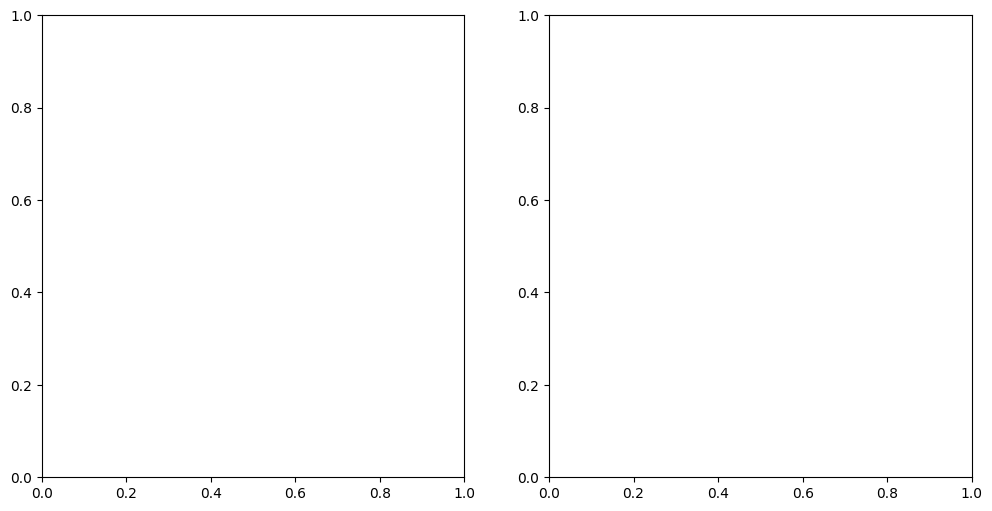

In [38]:
# Testing
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    preds = model(X_test)
    rmse = torch.sqrt(torch.mean(torch.pow(preds.mean - y_test, 2)))
    print(f"RMSE: {rmse}")

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(hist['loss'])
ax[0].set_title("Loss")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[1].scatter(y_test, preds.mean)
ax[1].plot([-1, 1], [-1, 1], color='red', linestyle='--')
ax[1].set_title("Predictions")
ax[1].set_xlabel("True")
ax[1].set_ylabel("Predicted")
plt.show()

In [88]:
# KAN based model

class KAN_extractor(nn.Module):
    def __init__(self):
        super(KAN_extractor, self).__init__()
        self.kan1 = KANLayer(
            in_dim=data_dim, out_dim=2*data_dim+1,
            num=5, k=3, base_fun=torch.nn.SiLU())
        self.kan2 = KANLayer(2*data_dim+1, 2,
            num=5, k=3, base_fun=torch.nn.SiLU())

    def forward(self, x):
        x, *_ = self.kan1(x)
        x, *_ = self.kan2(x)
        return x
        


class KAN_GPR(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(KAN_GPR, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.GridInterpolationKernel(
            gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=2)),
            num_dims=2, grid_size=50
        )
        self.feature_extractor = KAN_extractor()
        self.scaler = gpytorch.utils.grid.ScaleToBounds(-1, 1)

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.scaler(x)
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

likelihood = gpytorch.likelihoods.GaussianLikelihood()
kan_model = KAN_GPR(X_train, y_train, likelihood)

# number of parameters
print(f"Number of parameters: {sum(p.numel() for p in kan_model.parameters())}")

Number of parameters: 12585


In [89]:
# Training

epochs = 50

kan_model.train()
likelihood.train()

# Use the adam optimizer
optimizer = LBFGS(kan_model.parameters(), lr=0.1)

# Loss
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, kan_model)

def train():
    history = {'loss': []}  # Create a dictionary to store the history
    iterator = tqdm(range(epochs), desc="Epochs")
    for i in iterator:
        optimizer.zero_grad()
        output = kan_model(X_train)
        loss = -mll(output, y_train)
        loss.backward()
        optimizer.step()
        iterator.set_postfix(loss=loss.item())
        history['loss'].append(loss.item())  # Save the loss value at each epoch
    return history

hist_kan = train()

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

/Users/dangchan/miniforge3/envs/kan/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


TypeError: step() missing 1 required positional argument: 'closure'